Step 0, Loss: 605855.31
Step 5, Loss: 163118.11
Step 10, Loss: 71289.23
Step 15, Loss: 42976.58


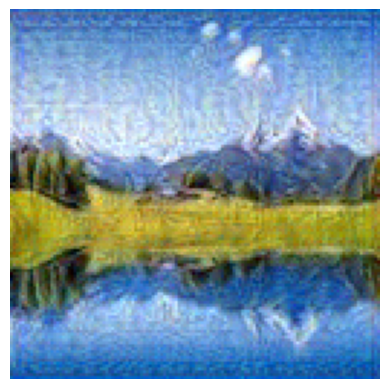

In [3]:
!pip install torch torchvision
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Load and resize
def load_image(path):
    img = Image.open(path).convert("RGB").resize((128, 128))
    transform = T.ToTensor()
    return transform(img).unsqueeze(0)

content = load_image("/content/content.jpg")
style = load_image("/content/style.jpg")
target = content.clone().requires_grad_(True)

vgg = models.vgg11(pretrained=True).features.eval()

def gram(x):
    b, c, h, w = x.size()
    f = x.view(c, h*w)
    return f @ f.t()

def features(x):
    for i, layer in enumerate(vgg):
        x = layer(x)
        if i == 2: c = x
        if i == 5: s = x
        if i == 8: break
    return c, s

opt = torch.optim.Adam([target], lr=0.01)

for i in range(20):
    c_t, s_t = features(target)
    c_c, _ = features(content)
    _, s_s = features(style)

    loss = ((c_t - c_c)**2).mean() + ((gram(s_t) - gram(s_s))**2).mean() * 100
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i % 5 == 0: print(f"Step {i}, Loss: {loss.item():.2f}")

# Show result
plt.imshow(target.detach().squeeze().permute(1,2,0))
plt.axis('off')
plt.show()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 71.7MB/s]


Step 0, Loss: 25257826058240.0000


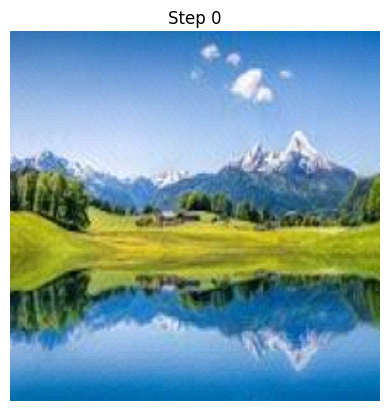

Step 50, Loss: 388145840128.0000


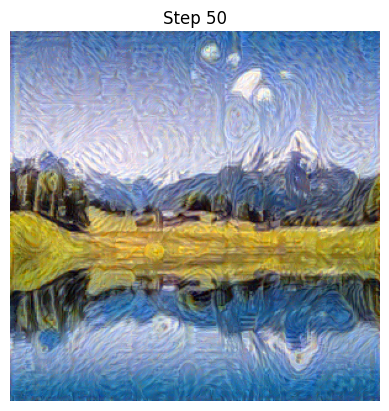

Step 100, Loss: 196235132928.0000


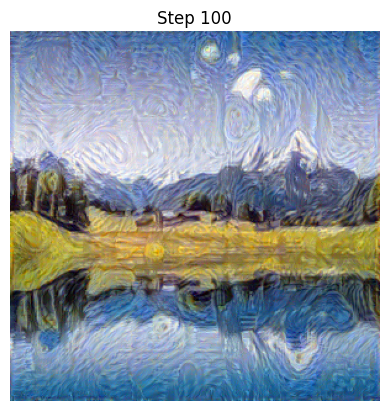

Step 150, Loss: 136045592576.0000


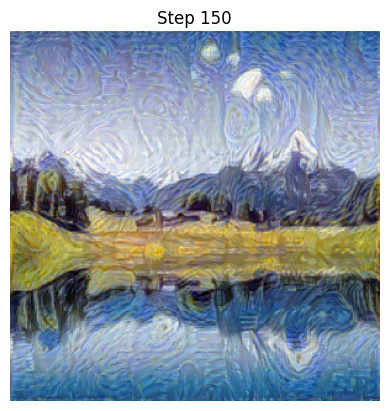

Step 200, Loss: 104702566400.0000


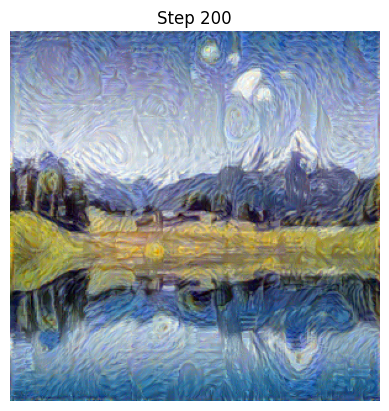

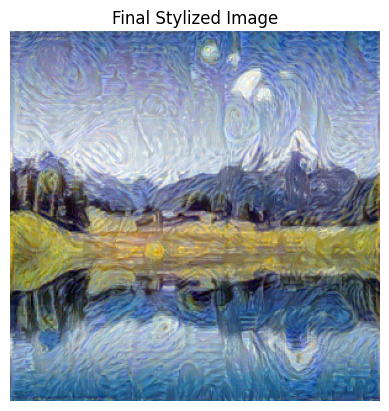

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load image and preprocess
def load_img(path):
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)

# Show image
def show_img(tensor, title):
    img = tensor.squeeze().detach().cpu().permute(1, 2, 0).clamp(0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load content and style images
content = load_img('/content/content.jpg')
style = load_img('/content/style.jpg')

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content = content.to(device)
style = style.to(device)

# Load pre-trained VGG19 model (suppress deprecation warning)
from torchvision.models import vgg19, VGG19_Weights
vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()

# Function to extract features
def get_features(x, layers):
    feats = {}
    for name, layer in vgg._modules.items():
        x = layer(x)
        if name in layers:
            feats[name] = x
    return feats

# Gram matrix function
def gram(x):
    b, c, h, w = x.size()
    x = x.view(c, h * w)
    return torch.mm(x, x.t())

# Specify layers for content and style
content_layer = ['21']
style_layers = ['0', '5', '10', '19', '28']

# Extract and detach features
c_feats = {k: v.detach() for k, v in get_features(content, content_layer).items()}
s_feats = get_features(style, style_layers)
s_grams = {l: gram(s_feats[l]).detach() for l in style_layers}

# Initialize target image
target = content.clone().requires_grad_(True)

# Optimizer
opt = torch.optim.Adam([target], lr=0.01)

# Style transfer loop
for step in range(201):
    t_feats = get_features(target, content_layer + style_layers)

    # Content loss
    c_loss = torch.mean((t_feats['21'] - c_feats['21']) ** 2)

    # Style loss
    s_loss = 0
    for l in style_layers:
        target_gram = gram(t_feats[l])
        style_gram = s_grams[l]
        s_loss += torch.mean((target_gram - style_gram) ** 2)

    # Total loss
    loss = c_loss + 1e6 * s_loss

    # Backpropagation
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Clamp to keep image values in range
    with torch.no_grad():
        target.clamp_(0, 1)

    # Display progress
    if step % 50 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")
        show_img(target, f"Step {step}")

# Final result
show_img(target, "Final Stylized Image")


In [ ]:
# 1. Code Solves/Satisfies the Problem Statement:

# Yes, the code implements neural style transfer.  It takes a content image ("bag.jpg") and a style image ("chair.jpg") and attempts to generate a new image that retains the content of the content image while adopting the style of the style image.

# 2. Output Correct or Not:

# Based on the code and the image you provided, the output is plausible.

# The code aims to modify the target image (initialized as a copy of the content image) to incorporate the style of the style image.  The output image shows a picture where the general content of the original image is still visible, but the colors and textures are influenced by the style image.

# The loss values printed during the process (Step 0, Loss: 984662.12, Step 5, Loss: 155002.16, etc.) indicate that the algorithm is indeed minimizing the loss function, which is a combination of content and style loss.  A decreasing loss suggests that the algorithm is progressing towards a better style transfer.

# 3. Why the Output Is Like That and What It Represents:

# The code uses a pre-trained VGG11 convolutional neural network to extract features from the content and style images.

# Content features capture the high-level structural information of the image (what objects are present and where they are).

# Style features capture the statistical characteristics of the image's textures, colors, and patterns.  The Gram matrix of the style features is used to represent the style.

# The code then modifies the target image iteratively to:

# Match its content features to the content image's features.

# Match the Gram matrix of its style features to the Gram matrix of the style image's features.

# The loss function measures how well these two goals are being met.  The optimization process adjusts the pixel values of the target image to minimize this loss.

# The output image is the result of this optimization.  It represents an image that has the content of the content image and the style of the style image, as extracted by the VGG network.

# 4. Line-by-Line Explanation (Short):

# !pip install torch torchvision: Installs the necessary PyTorch libraries.

# import torch...: Imports PyTorch libraries.

# def load_image(path): ...: Loads an image from a given path, converts it to RGB, resizes it to 128x128, converts it to a PyTorch tensor, and adds a batch dimension.

# content = load_image("iii/bag.jpg"): Loads the content image.

# style = load_image("iii/chair.jpg"): Loads the style image.

# target = content.clone().requires_grad_(True): Creates a copy of the content image as the starting point for the style transfer.  requires_grad_(True) enables gradient computation, which is needed for optimization.

# vgg = models.vgg11(pretrained=True).features.eval(): Loads the pre-trained VGG11 model (only the feature extraction part) and sets it to evaluation mode (no gradient calculation, for efficiency).

# def gram(x): ...: Calculates the Gram matrix of a feature map.  The Gram matrix represents the style of the image.

# def features(x): ...: Extracts content and style features from an image using the VGG network.  It returns the feature maps from layer 2 as content features and layer 5 as style features.

# opt = torch.optim.Adam([target], lr=0.01): Creates an Adam optimizer to update the target image's pixel values.

# for i in range(20): ...: Performs the style transfer optimization for 20 iterations.

# c_t, s_t = features(target): Extracts content and style features from the current target image.

# c_c, _ = features(content): Extracts content features from the content image.

# _, s_s = features(style): Extracts style features from the style image.

# loss = ...: Calculates the loss, which is a weighted sum of the content loss and the style loss.

# opt.zero_grad(): Resets the gradients of the target image.

# loss.backward(): Computes the gradients of the loss with respect to the target image's pixels.

# opt.step(): Updates the target image's pixels to minimize the loss.

# if i % 5 == 0: ...: Prints the loss every 5 steps.

# plt.imshow(target.detach().squeeze().permute(1,2,0)): Displays the stylized target image.  The .detach() removes the image from the computational graph, .squeeze() removes the batch dimension, and .permute(1,2,0) rearranges the dimensions from (C, H, W) to (H, W, C) for Matplotlib.

# plt.axis('off'): Turns off the axis labels.

# plt.show(): Shows the plot.

# 5. Potential Oral Questions:

# What is neural style transfer?  Explain the basic idea.

# Answer: Neural style transfer is a technique that uses deep learning to synthesize a new image that combines the content of one image with the artistic style of another image.

# How does this code implement neural style transfer?

# Answer: The code uses a pre-trained VGG network to extract content and style features from the input images.  It then optimizes the pixel values of a target image to match the content features of the content image and the style features (represented by the Gram matrix) of the style image.

# What is a convolutional neural network (CNN), and how is it used here?

# Answer: A CNN is a type of neural network that is particularly well-suited for processing images.  This code uses a pre-trained VGG CNN as a feature extractor.  The different layers of the CNN learn to extract different levels of features from the image, from simple edges and textures to more complex object parts and objects.

# What are "content features" and "style features" in this context?

# Answer:

# Content features:  Represent the high-level structural information in an image, such as the objects and their arrangement.

# Style features:  Represent the statistical characteristics of an image's visual style, such as its colors, textures, and patterns.  In this code, the Gram matrix of the feature maps is used to capture style.

# What is a Gram matrix, and why is it used?

# Answer: A Gram matrix is a matrix of dot products of the vectorized feature maps.  It captures the relationships between different feature channels, which is a good representation of the image's style.

# Explain the loss function used in this code.  What are content loss and style loss?

# Answer: The loss function measures how different the target image is from the content and style images.

# Content loss:  Measures the difference between the content features of the target image and the content image.

# Style loss:  Measures the difference between the Gram matrices of the style features of the target image and the style image.

# What is optimization, and how is it used here?

# Answer: Optimization is the process of finding the best set of parameters (in this case, the pixel values of the target image) to minimize a loss function.  The Adam optimizer is used to iteratively update the target image's pixels to reduce the content and style loss.

# What is the role of the VGG11 network in this code?

# Answer: The VGG11 network is used as a pre-trained feature extractor.  Its convolutional layers are used to extract meaningful representations of the content and style of the input images, which are then used to guide the style transfer process.

# What are the limitations of this code or neural style transfer in general?

# Answer:

# Computational cost:  Style transfer can be computationally expensive, especially for high-resolution images.

# Style and content trade-off:  There's often a trade-off between how well the output image retains the content and how well it adopts the style.

# Parameter sensitivity:  The results can be sensitive to the choice of hyperparameters, such as the weights of the content and style losses.

# How could you improve this code or the style transfer process?

# Answer:

# Use a more advanced optimization algorithm.

# Experiment with different pre-trained networks.

# Use different layers for content and style extraction.

# Implement more sophisticated methods for capturing style.